<center><img src="../../logo.png" alt="drawing" width="400" style="background-color:white; padding:1em;" /></center> <br/>

# Application of Deep Learning to Text and Image Data
## Module 3, Lab 6: Fine-Tuning ConvNeXt

This notebook will show you how to import a pretrained ConvNeXt model and fine-tune it to solve a classification problem. You will train this model with a dataset and then test and visualize the results.

You will learn how to do the following:

- Load and transform the ConvNeXt dataset
- Fine-tune the model to fit your data
- Test, evaluate, and visualize the results

----

You will be presented with a challenge at the end of this lab:

| <img style="float: center;" src="../../challenge.png" alt="Challenge" width="125"/> |
| --- |
| <p style="text-align:center;">Challenges are where you can practice your coding skills.</p> |

## Index

- [Loading and transforming the dataset](#Loading-and-transforming-the-dataset)
- [Fine-tuning the model](#Fine-tuning-the-model)
- [Testing and visualizations](#Testing-and-visualizations)

---
## Loading and transforming the dataset

You will be fine-tuning a ConvNeXt model to work with the Materials in Context Database (MINC). To start, use the same steps as the previous lab to use transform functions and create data loaders to load the data.

Reference: Sean Bell, Paul Upchurch, Noah Snavely, and Kavita Bala. "Material Recognition in the Wild with the Materials in Context Database." *Computer Vision and Pattern Recognition (CVPR)*, April 2015. https://arxiv.org/abs/1412.0623.

In [1]:
%%capture
# Install libraries
!pip install -U -q -r requirements.txt

Import the PyTorch packages and modules. 

In [2]:
import os
import matplotlib.pyplot as plt
import torch, torchvision
from PIL import Image
from torch import nn
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torch.optim import SGD
from torchvision.models import convnext_base, convnext_tiny, convnext_small

In [3]:
# Transform the images
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0,0,0), std=(1,1,1))
])

# Create the data loaders
batch_size = 16
#path = '/home/ec2-user/SageMaker/data/minc-2500'  # for MLU internal test only
path = 'data/minc-2500'
train_path = os.path.join(path, 'train')
val_path = os.path.join(path, 'val')
test_path = os.path.join(path, 'test')

train_loader = DataLoader(
    ImageFolder(train_path, transform=transform),
    batch_size=batch_size, shuffle=True)

validation_loader = DataLoader(
    ImageFolder(val_path, transform=transform),
    batch_size=batch_size, shuffle=False)

test_loader = DataLoader(
    ImageFolder(test_path, transform=transform),
    batch_size=batch_size, shuffle=False)

---
## Fine-tuning the model

You can start with a base model and fine-tune it to improve its performance with the dataset that you are using. This helps you to create a better model using fewer resources.

You will take the following steps:
1. Start with a ConvNeXt model that was trained with the ImageNet dataset as the base model.
1. Import the `convnext_tiny` model with the `IMAGENET1K_V1` weights.
1. The original ConvNeXt model was trained for 1,000 categories. Update the last layer with a dense layer that has the same number of classes for the problem that you want to solve (6, in this case).

In [4]:
classes = 6

# Use GPU resource if available; otherwise use CPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

net = convnext_tiny(weights="IMAGENET1K_V1").to(device)

# Print the network to find out how to access the last layer
print(net)

ConvNeXt(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
      (1): LayerNorm2d((96,), eps=1e-06, elementwise_affine=True)
    )
    (1): Sequential(
      (0): CNBlock(
        (block): Sequential(
          (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
          (1): Permute()
          (2): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
          (3): Linear(in_features=96, out_features=384, bias=True)
          (4): GELU(approximate='none')
          (5): Linear(in_features=384, out_features=96, bias=True)
          (6): Permute()
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): CNBlock(
        (block): Sequential(
          (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
          (1): Permute()
          (2): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
          (3): Linear(in_features=

Read through the output from the last command. The last layer (a linear layer) is under the __classifier__ part of the network. You can access this layer by using `net.classifier[2]`.

Now that you have a classifier layer to work from, you need to create a new linear layer that has the same number of inputs and has a preselected number of outputs (6 here).

In [5]:
num_ftrs = net.classifier[2].in_features

# Update the classifier so that it uses the classes that are defined for your problem
net.classifier[2] = nn.Linear(num_ftrs, classes)

Now, train the model.

In [6]:
%%time
epochs = 5
learning_rate = 0.001
criterion = nn.CrossEntropyLoss()

optimizer = SGD(net.parameters(), lr=learning_rate)

def calculate_accuracy(output, label):
    """Calculate the accuracy of the trained network. 
    output: (batch_size, num_output) float32 tensor
    label: (batch_size, ) int32 tensor """

    return (output.argmax(axis=1) == label.float()).float().mean()

for epoch in range(epochs):
    net = net.to(device) # may be redundant

    train_loss, val_loss, train_acc, valid_acc = 0., 0., 0., 0.

    # Training loop
    # This loop trains the neural network (weights are updated)
    net.train() # Activate training mode
    for data, label in train_loader:
        # Zero the parameter gradients
        optimizer.zero_grad()
        # Put data and label to the correct device
        data = data.to(device)
        label = label.to(device)
        # Make forward pass
        output = net(data)
        # Calculate loss
        loss = criterion(output, label)
        # Make backward pass (calculate gradients)
        loss.backward()
        # Accumulate training accuracy and loss
        train_acc += calculate_accuracy(output, label).item()
        train_loss += loss.item()
        # Update weights
        optimizer.step()

    # Validation loop
    # This loop tests the trained network on the validation dataset
    # No weight updates here
    # torch.no_grad() reduces memory usage when not training the network
    net.eval() # Activate evaluation mode
    with torch.no_grad():
        for data, label in validation_loader:
            data = data.to(device)
            label = label.to(device)
            # Make forward pass with the trained model so far
            output = net(data)
            # Accumulate validation accuracy and loss
            valid_acc += calculate_accuracy(output, label).item()
            val_loss += criterion(output, label).item()

    # Take averages
    train_loss /= len(train_loader)
    train_acc /= len(train_loader)
    val_loss /= len(validation_loader)
    valid_acc /= len(validation_loader)

    print("Epoch %d: train loss %.3f, train acc %.3f, val loss %.3f, val acc %.3f" % (
        epoch+1, train_loss, train_acc, val_loss, valid_acc))

Epoch 1: train loss 1.490, train acc 0.470, val loss 1.078, val acc 0.745
Epoch 2: train loss 0.849, train acc 0.819, val loss 0.611, val acc 0.859
Epoch 3: train loss 0.546, train acc 0.878, val loss 0.441, val acc 0.922
Epoch 4: train loss 0.400, train acc 0.912, val loss 0.425, val acc 0.917
Epoch 5: train loss 0.298, train acc 0.935, val loss 0.398, val acc 0.906
CPU times: user 4min 16s, sys: 5.08 s, total: 4min 21s
Wall time: 2min 25s


---
## Testing and visualizations

Now that you have created a model, you need to validate the model's predictions.

The following code cell defines the `show_images` function. It will show the sample images and the model prediction together.

In [7]:
def show_images(imgs, num_rows, num_cols, titles=None, scale=1.5):
    """Plot a list of images."""
    figsize = (num_cols * scale, num_rows * scale)
    _, axes = plt.subplots(num_rows, num_cols, figsize=figsize)
    axes = axes.flatten()
    for i, (ax, img) in enumerate(zip(axes, imgs)):
        ax.imshow(img.permute(1,2,0).numpy())
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
        if titles:
            ax.set_title(titles[i])
    return axes

Now that you have trained a model and created a function to test predictions, you are ready to load the test dataset, make predictions, and evaluate the predictions.

tensor([0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


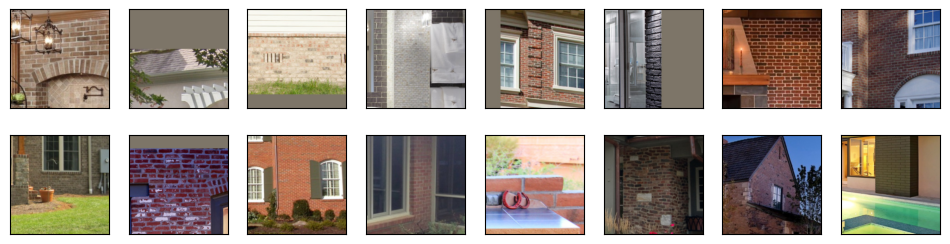

In [8]:
random_test_dataset = ImageFolder(test_path,
                                  transform=transform)
random_test_sample = DataLoader(random_test_dataset,
                                batch_size=2*8, shuffle=False)

net.eval() # Activate eval mode (don't use dropouts etc.)
for data, label in random_test_sample:
    show_images(data, 2, 8);
    data = data.to(device)
    pred = net(data)
    print(pred.argmax(axis=1))
    break

It shows 16 sample images in the test set above. The 16 values in the tensor are the prediction results for these 16 images. 
The labels are brick(0), carpet(1), food(2), mirror(3), sky(4), and water(5).


<div style="border: 4px solid coral; text-align: center; margin: auto;"> 
    <h3><i>Try it yourself!</i></h3>
    <p style="text-align:center; margin:auto;"><img src="../../challenge.png" alt="Challenge" width="100" /> </p>
    <p style=" text-align: center; margin: auto;">ConvNeXt comes in different sizes, including <code>convnext_small</code>, <code>convnext_base</code>, and <code>convnext_large</code>.</p><br>
    <p style=" text-align: center; margin: auto;">Pick one of these models, and use the following code cell to retrain your model.</p><br>
    <p style=" text-align: center; margin: auto;">You only need to import the new model and replace <code>convnext_tiny</code> with <code>convnext_small</code>, <code>convnext_base</code>, or <code>convnext_large</code>, and retrain the model.</p><br>
    
</div>

In [9]:
device

device(type='cuda', index=0)

In [10]:
############### CODE HERE ###############

challenge_net = convnext_base(weights="IMAGENET1K_V1").to(device)
print(challenge_net)

challenge_num_ftrs = challenge_net.classifier[2].in_features

# Update the classifier so that it uses the classes that are defined for your problem
challenge_net.classifier[2] = nn.Linear(challenge_num_ftrs, classes)

############## END OF CODE ##############

ConvNeXt(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 128, kernel_size=(4, 4), stride=(4, 4))
      (1): LayerNorm2d((128,), eps=1e-06, elementwise_affine=True)
    )
    (1): Sequential(
      (0): CNBlock(
        (block): Sequential(
          (0): Conv2d(128, 128, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=128)
          (1): Permute()
          (2): LayerNorm((128,), eps=1e-06, elementwise_affine=True)
          (3): Linear(in_features=128, out_features=512, bias=True)
          (4): GELU(approximate='none')
          (5): Linear(in_features=512, out_features=128, bias=True)
          (6): Permute()
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): CNBlock(
        (block): Sequential(
          (0): Conv2d(128, 128, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=128)
          (1): Permute()
          (2): LayerNorm((128,), eps=1e-06, elementwise_affine=True)
          (3): Linear(

In [11]:
%%time
epochs = 5
learning_rate = 0.001
criterion = nn.CrossEntropyLoss()

challenge_optimizer = SGD(challenge_net.parameters(), lr=learning_rate)

for epoch in range(epochs):
    challenge_net = challenge_net.to(device) # may be redundant

    train_loss, val_loss, train_acc, valid_acc = 0., 0., 0., 0.

    # Training loop
    # This loop trains the neural network (weights are updated)
    challenge_net.train() # Activate training mode
    for data, label in train_loader:
        # Zero the parameter gradients
        challenge_optimizer.zero_grad()
        # Put data and label to the correct device
        data = data.to(device)
        label = label.to(device)
        # Make forward pass
        output = challenge_net(data)
        # Calculate loss
        loss = criterion(output, label)
        # Make backward pass (calculate gradients)
        loss.backward()
        # Accumulate training accuracy and loss
        train_acc += calculate_accuracy(output, label).item()
        train_loss += loss.item()
        # Update weights
        challenge_optimizer.step()

    # Validation loop
    # This loop tests the trained network on the validation dataset
    # No weight updates here
    # torch.no_grad() reduces memory usage when not training the network
    challenge_net.eval() # Activate evaluation mode
    with torch.no_grad():
        for data, label in validation_loader:
            data = data.to(device)
            label = label.to(device)
            # Make forward pass with the trained model so far
            output = challenge_net(data)
            # Accumulate validation accuracy and loss
            valid_acc += calculate_accuracy(output, label).item()
            val_loss += criterion(output, label).item()

    # Take averages
    train_loss /= len(train_loader)
    train_acc /= len(train_loader)
    val_loss /= len(validation_loader)
    valid_acc /= len(validation_loader)

    print("Epoch %d: train loss %.3f, train acc %.3f, val loss %.3f, val acc %.3f" % (
        epoch+1, train_loss, train_acc, val_loss, valid_acc))

Epoch 1: train loss 1.610, train acc 0.412, val loss 1.311, val acc 0.750
Epoch 2: train loss 1.165, train acc 0.772, val loss 0.875, val acc 0.875
Epoch 3: train loss 0.837, train acc 0.879, val loss 0.629, val acc 0.896
Epoch 4: train loss 0.619, train acc 0.903, val loss 0.478, val acc 0.911
Epoch 5: train loss 0.490, train acc 0.908, val loss 0.426, val acc 0.932
CPU times: user 7min 59s, sys: 20.9 s, total: 8min 20s
Wall time: 6min 19s


tensor([0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


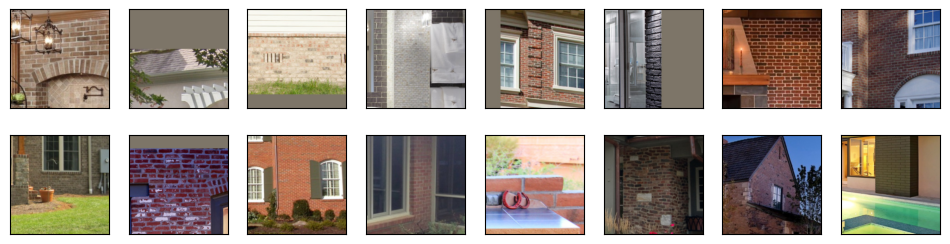

In [12]:
random_test_dataset = ImageFolder(test_path,
                                  transform=transform)
random_test_sample = DataLoader(random_test_dataset,
                                batch_size=2*8, shuffle=False)

challenge_net.eval() # Activate eval mode (don't use dropouts etc.)
for data, label in random_test_sample:
    show_images(data, 2, 8);
    data = data.to(device)
    pred = challenge_net(data)
    print(pred.argmax(axis=1))
    break

Now you have tried a different size of the ConvNeXt model. You can also follow the same steps above in this notebook to further evaluate your new trained model.

## Conclusion

In this lab, you learned how to fine-tune the ConvNeXt model to make better predictions that fit your dataset without training your own model. This is an easy way to quickly get started making predictions at a lower cost. The biggest problem is that the model will probably not fit your dataset well, which will require you to fine-tune the model. Fine-tuning improves model accuracy so that the model will make good predictions for your dataset.

__Congratulations! You have finished the last lab in this course.__